## 물고기 분류기

In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pathlib
from keras.optimizers import Adam

### CUDA error 잡기
- TF와 내부 CUDA 버전 안 맞을 때 에러 나는 경우가 많음
- 해당 문제를 해결하기 위해 아래의 버전 맞추기 코드를 붙여넣자

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## 데이터셋 불러오기
- 현재 디렉토리의 위치를 기준으로 데이터가 있는 path를 지정해준다
- 맞는 path인지 확인하기 위해 데이터의 전체 갯수를 세서 리턴한다

In [3]:
# 데이터셋 불러오기
data_dir = pathlib.Path('./dataset')
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.jpeg'))) + len(list(data_dir.glob('*/*.png')))

print(f'total number of data: {image_count}')

total number of data: 396


In [4]:
batch_size = 16
img_height = 112
img_width = 112

keras.preprocessing = 디스크의 이미지 디렉토리를 `tf.data.Dataset`으로 가져옴
= 그냥 이미지 로드해주는 애

검증 분할 = training:validation 비율을 8:2로 정해줌

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 396 files belonging to 6 classes.
Using 278 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 396 files belonging to 6 classes.
Using 118 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다.

In [7]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)
print(num_classes)

['catfish_메기', 'crucian carp_붕어', 'flatfish_광어', 'golden mandarin fish_쏘가리', 'red snapper_참돔', 'rockfish_우럭']
6


In [8]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 112, 112, 3)
(16,)


`image_batch`는 형상 `(32, 180, 180, 3)`의 텐서입니다. 이것은 형상 `180x180x3`의 32개 이미지 배치입니다(마지막 치수는 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.


참고: 이들 텐서 중 하나에서 `.numpy()`를 호출하여 `numpy.ndarray`로 변환할 수 있습니다.

### Visualizing the data

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])][:len(class_names[int(labels[i])]) - 3])
        plt.axis("off")

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])][:len(class_names[int(labels[i])]) - 3])
        plt.axis("off")

### 데이터 표준화하기


RGB 채널 값은 `[0, 255]` 범위에 있습니다. 신경망에는 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다. 여기서는 Rescaling 레이어를 사용하여 값이 `[0, 1]`에 있도록 표준화합니다.

IMG_SIZE = 224

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

이 레이어를 사용하는 방법에는 두 가지가 있습니다. map을 호출하여 데이터세트에 레이어를 적용할 수 있습니다.

# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.1),
# ])

또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기서는 두 번째 접근 방식을 사용할 것입니다.

참고: 픽셀 값을 `[-1,1]`으로 조정하려면 대신 `Rescaling(1./127.5, offset=-1)`를 작성할 수 있습니다.

참고: 이전에 `image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 모델에 크기 조정 논리를 포함하려면 [Resizing](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) 레이어를 대신 사용할 수 있습니다.


### 성능을 위한 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O가 차단되지 않고 디스크에서 데이터를 생성할 수 있도록 합니다. 데이터를 로드할 때 사용해야 하는 두 가지 중요한 메서드입니다.

`.cache()`는 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

`.prefetch()`는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

관심 있는 독자는 [데이터 성능 가이드](https://www.tensorflow.org/guide/data_performance#prefetching)에서 두 가지 메서드와 디스크에 데이터를 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [ ]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixels values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

### 모델 훈련하기

완전성을 위해 준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여줍니다. 이 모델은 어떤 식으로든 조정되지 않았습니다. 목표는 방금 만든 데이터세트를 사용하여 역학을 보여주는 것입니다. 이미지 분류에 대한 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/tutorials/images/classification)을 참조하세요.

In [ ]:
# model = tf.keras.Sequential([
#     resize_and_rescale,
# #     data_augmentation,
#     layers.Conv2D(16, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(32, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Conv2D(64, 3, padding='same', activation='relu'),
#     layers.MaxPooling2D(),
    
#     layers.Dropout(0.2),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dense(num_classes, activation='softmax')
# ])

In [10]:
model = tf.keras.Sequential()

# 224x224 RGB images as input
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
# model.add(tf.keras.Input(shape=(img_height, img_width, 3)))

# adding layers
# batch normalization, dropout = overfitting 방지rfitting 방지
model.add(layers.Conv2D(64, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.Conv2D(64, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.Conv2D(128, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(256, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.Conv2D(256, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(512, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.Conv2D(512, 3, strides = (1,1), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# 2차원의 그림을 1차원을 바꿔준다
model.add(layers.Flatten())

# 입력계층의 갯수 정하기
model.add(layers.Dense(1024, activation='relu'))

# output layer
# 가진 클래스의 갯수만큼 출력층 만들어주기
model.add(layers.Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 112, 112, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 128)       0

In [11]:
opt = Adam(lr=0.00001)

model.compile(
    optimizer=opt,
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

참고: 몇 가지 epoch에 대해서만 훈련하므로 이 튜토리얼은 빠르게 진행됩니다. 

In [12]:
epochs = 1000
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

hdf5_file = "./model/improved_model_1.hdf5"
model.save_weights(hdf5_file)

Epoch 1/1000
18/18 [==============================] - 8s 192ms/step - loss: 1.7899 - accuracy: 0.2124 - val_loss: 1.7825 - val_accuracy: 0.3051
Epoch 2/1000
18/18 [==============================] - 2s 92ms/step - loss: 1.7708 - accuracy: 0.3341 - val_loss: 1.7798 - val_accuracy: 0.2203
Epoch 3/1000
18/18 [==============================] - 2s 91ms/step - loss: 1.7498 - accuracy: 0.3078 - val_loss: 1.7712 - val_accuracy: 0.2034
Epoch 4/1000
18/18 [==============================] - 2s 90ms/step - loss: 1.7129 - accuracy: 0.2893 - val_loss: 1.7214 - val_accuracy: 0.2542
Epoch 5/1000
18/18 [==============================] - 2s 91ms/step - loss: 1.6320 - accuracy: 0.3500 - val_loss: 1.6221 - val_accuracy: 0.3220
Epoch 6/1000
18/18 [==============================] - 2s 91ms/step - loss: 1.5120 - accuracy: 0.3936 - val_loss: 1.5561 - val_accuracy: 0.3475
Epoch 7/1000
18/18 [==============================] - 2s 91ms/step - loss: 1.4309 - accuracy: 0.4311 - val_loss: 1.5194 - val_accuracy: 0.322

Epoch 58/1000
18/18 [==============================] - 2s 104ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.6318 - val_accuracy: 0.6949
Epoch 59/1000
18/18 [==============================] - 2s 105ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.6485 - val_accuracy: 0.6949
Epoch 60/1000
18/18 [==============================] - 2s 109ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 1.6634 - val_accuracy: 0.6949
Epoch 61/1000
18/18 [==============================] - 2s 107ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 1.6788 - val_accuracy: 0.6949
Epoch 62/1000
18/18 [==============================] - 2s 104ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.6937 - val_accuracy: 0.6949
Epoch 63/1000
18/18 [==============================] - 2s 100ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 1.7073 - val_accuracy: 0.6949
Epoch 64/1000
18/18 [==============================] - 2s 98ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 1.7214 - val_acc

18/18 [==============================] - 2s 95ms/step - loss: 1.4550e-04 - accuracy: 1.0000 - val_loss: 2.4314 - val_accuracy: 0.6949
Epoch 170/1000
18/18 [==============================] - 2s 95ms/step - loss: 1.4268e-04 - accuracy: 1.0000 - val_loss: 2.4358 - val_accuracy: 0.6949
Epoch 171/1000
18/18 [==============================] - 2s 95ms/step - loss: 1.3987e-04 - accuracy: 1.0000 - val_loss: 2.4403 - val_accuracy: 0.6949
Epoch 172/1000
18/18 [==============================] - 2s 96ms/step - loss: 1.3715e-04 - accuracy: 1.0000 - val_loss: 2.4449 - val_accuracy: 0.6949
Epoch 173/1000
18/18 [==============================] - 2s 95ms/step - loss: 1.3442e-04 - accuracy: 1.0000 - val_loss: 2.4494 - val_accuracy: 0.6864
Epoch 174/1000
18/18 [==============================] - 2s 94ms/step - loss: 1.3189e-04 - accuracy: 1.0000 - val_loss: 2.4539 - val_accuracy: 0.6864
Epoch 175/1000
18/18 [==============================] - 2s 95ms/step - loss: 1.2933e-04 - accuracy: 1.0000 - val_loss: 2.

18/18 [==============================] - 2s 96ms/step - loss: 5.4118e-05 - accuracy: 1.0000 - val_loss: 2.6635 - val_accuracy: 0.6949
Epoch 225/1000
18/18 [==============================] - 2s 97ms/step - loss: 5.3261e-05 - accuracy: 1.0000 - val_loss: 2.6676 - val_accuracy: 0.6949
Epoch 226/1000
18/18 [==============================] - 2s 96ms/step - loss: 5.2396e-05 - accuracy: 1.0000 - val_loss: 2.6713 - val_accuracy: 0.6949
Epoch 227/1000
18/18 [==============================] - 2s 97ms/step - loss: 5.1546e-05 - accuracy: 1.0000 - val_loss: 2.6758 - val_accuracy: 0.6949
Epoch 228/1000
18/18 [==============================] - 2s 97ms/step - loss: 5.0689e-05 - accuracy: 1.0000 - val_loss: 2.6794 - val_accuracy: 0.6949
Epoch 229/1000
18/18 [==============================] - 2s 98ms/step - loss: 4.9921e-05 - accuracy: 1.0000 - val_loss: 2.6834 - val_accuracy: 0.6949
Epoch 230/1000
18/18 [==============================] - 2s 96ms/step - loss: 4.9055e-05 - accuracy: 1.0000 - val_loss: 2.

18/18 [==============================] - 2s 98ms/step - loss: 2.2938e-05 - accuracy: 1.0000 - val_loss: 2.8743 - val_accuracy: 0.6949
Epoch 280/1000
18/18 [==============================] - 2s 98ms/step - loss: 2.2601e-05 - accuracy: 1.0000 - val_loss: 2.8779 - val_accuracy: 0.6949
Epoch 281/1000
18/18 [==============================] - 2s 99ms/step - loss: 2.2279e-05 - accuracy: 1.0000 - val_loss: 2.8816 - val_accuracy: 0.6949
Epoch 282/1000
18/18 [==============================] - 2s 98ms/step - loss: 2.1950e-05 - accuracy: 1.0000 - val_loss: 2.8853 - val_accuracy: 0.6949
Epoch 283/1000
18/18 [==============================] - 2s 97ms/step - loss: 2.1629e-05 - accuracy: 1.0000 - val_loss: 2.8887 - val_accuracy: 0.6949
Epoch 284/1000
18/18 [==============================] - 2s 97ms/step - loss: 2.1304e-05 - accuracy: 1.0000 - val_loss: 2.8925 - val_accuracy: 0.6949
Epoch 285/1000
18/18 [==============================] - 2s 97ms/step - loss: 2.0995e-05 - accuracy: 1.0000 - val_loss: 2.

18/18 [==============================] - 2s 98ms/step - loss: 1.0515e-05 - accuracy: 1.0000 - val_loss: 3.0641 - val_accuracy: 0.7034
Epoch 335/1000
18/18 [==============================] - 2s 97ms/step - loss: 1.0364e-05 - accuracy: 1.0000 - val_loss: 3.0673 - val_accuracy: 0.7034
Epoch 336/1000
18/18 [==============================] - 2s 97ms/step - loss: 1.0233e-05 - accuracy: 1.0000 - val_loss: 3.0709 - val_accuracy: 0.7034
Epoch 337/1000
18/18 [==============================] - 2s 97ms/step - loss: 1.0098e-05 - accuracy: 1.0000 - val_loss: 3.0738 - val_accuracy: 0.7034
Epoch 338/1000
18/18 [==============================] - 2s 99ms/step - loss: 9.9649e-06 - accuracy: 1.0000 - val_loss: 3.0773 - val_accuracy: 0.7034
Epoch 339/1000
18/18 [==============================] - 2s 97ms/step - loss: 9.8307e-06 - accuracy: 1.0000 - val_loss: 3.0805 - val_accuracy: 0.7034
Epoch 340/1000
18/18 [==============================] - 2s 97ms/step - loss: 9.6954e-06 - accuracy: 1.0000 - val_loss: 3.

18/18 [==============================] - 2s 97ms/step - loss: 5.1190e-06 - accuracy: 1.0000 - val_loss: 3.2423 - val_accuracy: 0.7034
Epoch 390/1000
18/18 [==============================] - 2s 98ms/step - loss: 5.0585e-06 - accuracy: 1.0000 - val_loss: 3.2456 - val_accuracy: 0.7034
Epoch 391/1000
18/18 [==============================] - 2s 97ms/step - loss: 4.9952e-06 - accuracy: 1.0000 - val_loss: 3.2487 - val_accuracy: 0.7034
Epoch 392/1000
18/18 [==============================] - 2s 97ms/step - loss: 4.9292e-06 - accuracy: 1.0000 - val_loss: 3.2519 - val_accuracy: 0.7034
Epoch 393/1000
18/18 [==============================] - 2s 97ms/step - loss: 4.8658e-06 - accuracy: 1.0000 - val_loss: 3.2552 - val_accuracy: 0.7034
Epoch 394/1000
18/18 [==============================] - 2s 97ms/step - loss: 4.8027e-06 - accuracy: 1.0000 - val_loss: 3.2582 - val_accuracy: 0.7034
Epoch 395/1000
18/18 [==============================] - 2s 97ms/step - loss: 4.7479e-06 - accuracy: 1.0000 - val_loss: 3.

18/18 [==============================] - 2s 97ms/step - loss: 2.5913e-06 - accuracy: 1.0000 - val_loss: 3.4127 - val_accuracy: 0.7034
Epoch 445/1000
18/18 [==============================] - 2s 99ms/step - loss: 2.5604e-06 - accuracy: 1.0000 - val_loss: 3.4156 - val_accuracy: 0.7034
Epoch 446/1000
18/18 [==============================] - 2s 97ms/step - loss: 2.5285e-06 - accuracy: 1.0000 - val_loss: 3.4187 - val_accuracy: 0.7034
Epoch 447/1000
18/18 [==============================] - 2s 98ms/step - loss: 2.5007e-06 - accuracy: 1.0000 - val_loss: 3.4215 - val_accuracy: 0.7034
Epoch 448/1000
18/18 [==============================] - 2s 96ms/step - loss: 2.4677e-06 - accuracy: 1.0000 - val_loss: 3.4246 - val_accuracy: 0.7034
Epoch 449/1000
18/18 [==============================] - 2s 98ms/step - loss: 2.4421e-06 - accuracy: 1.0000 - val_loss: 3.4274 - val_accuracy: 0.7034
Epoch 450/1000
18/18 [==============================] - 2s 97ms/step - loss: 2.4116e-06 - accuracy: 1.0000 - val_loss: 3.

18/18 [==============================] - 2s 97ms/step - loss: 1.3700e-06 - accuracy: 1.0000 - val_loss: 3.5729 - val_accuracy: 0.7034
Epoch 500/1000
18/18 [==============================] - 2s 96ms/step - loss: 1.3535e-06 - accuracy: 1.0000 - val_loss: 3.5758 - val_accuracy: 0.7034
Epoch 501/1000
18/18 [==============================] - 2s 98ms/step - loss: 1.3390e-06 - accuracy: 1.0000 - val_loss: 3.5785 - val_accuracy: 0.7034
Epoch 502/1000
18/18 [==============================] - 2s 98ms/step - loss: 1.3229e-06 - accuracy: 1.0000 - val_loss: 3.5813 - val_accuracy: 0.7034
Epoch 503/1000
18/18 [==============================] - 2s 97ms/step - loss: 1.3091e-06 - accuracy: 1.0000 - val_loss: 3.5843 - val_accuracy: 0.7034
Epoch 504/1000
18/18 [==============================] - 2s 97ms/step - loss: 1.2958e-06 - accuracy: 1.0000 - val_loss: 3.5870 - val_accuracy: 0.7034
Epoch 505/1000
18/18 [==============================] - 2s 98ms/step - loss: 1.2800e-06 - accuracy: 1.0000 - val_loss: 3.

18/18 [==============================] - 2s 97ms/step - loss: 7.1554e-07 - accuracy: 1.0000 - val_loss: 3.7420 - val_accuracy: 0.7034
Epoch 555/1000
18/18 [==============================] - 2s 97ms/step - loss: 7.0978e-07 - accuracy: 1.0000 - val_loss: 3.7448 - val_accuracy: 0.7034
Epoch 556/1000
18/18 [==============================] - 2s 95ms/step - loss: 7.0153e-07 - accuracy: 1.0000 - val_loss: 3.7474 - val_accuracy: 0.7034
Epoch 557/1000
18/18 [==============================] - 2s 97ms/step - loss: 6.9489e-07 - accuracy: 1.0000 - val_loss: 3.7506 - val_accuracy: 0.7034
Epoch 558/1000
18/18 [==============================] - 2s 97ms/step - loss: 6.8803e-07 - accuracy: 1.0000 - val_loss: 3.7531 - val_accuracy: 0.7034
Epoch 559/1000
18/18 [==============================] - 2s 97ms/step - loss: 6.8235e-07 - accuracy: 1.0000 - val_loss: 3.7561 - val_accuracy: 0.7034
Epoch 560/1000
18/18 [==============================] - 2s 97ms/step - loss: 6.7434e-07 - accuracy: 1.0000 - val_loss: 3.

18/18 [==============================] - 2s 97ms/step - loss: 4.0181e-07 - accuracy: 1.0000 - val_loss: 3.8862 - val_accuracy: 0.7034
Epoch 610/1000
18/18 [==============================] - 2s 97ms/step - loss: 3.9908e-07 - accuracy: 1.0000 - val_loss: 3.8886 - val_accuracy: 0.7034
Epoch 611/1000
18/18 [==============================] - 2s 97ms/step - loss: 3.9827e-07 - accuracy: 1.0000 - val_loss: 3.8913 - val_accuracy: 0.7034
Epoch 612/1000
18/18 [==============================] - 2s 97ms/step - loss: 3.9327e-07 - accuracy: 1.0000 - val_loss: 3.8939 - val_accuracy: 0.7034
Epoch 613/1000
18/18 [==============================] - 2s 98ms/step - loss: 3.8647e-07 - accuracy: 1.0000 - val_loss: 3.8962 - val_accuracy: 0.7034
Epoch 614/1000
18/18 [==============================] - 2s 96ms/step - loss: 3.8143e-07 - accuracy: 1.0000 - val_loss: 3.8987 - val_accuracy: 0.7034
Epoch 615/1000
18/18 [==============================] - 2s 98ms/step - loss: 3.7687e-07 - accuracy: 1.0000 - val_loss: 3.

18/18 [==============================] - 2s 98ms/step - loss: 2.3617e-07 - accuracy: 1.0000 - val_loss: 4.0227 - val_accuracy: 0.7034
Epoch 665/1000
18/18 [==============================] - 2s 97ms/step - loss: 2.3336e-07 - accuracy: 1.0000 - val_loss: 4.0255 - val_accuracy: 0.7034
Epoch 666/1000
18/18 [==============================] - 2s 97ms/step - loss: 2.2848e-07 - accuracy: 1.0000 - val_loss: 4.0282 - val_accuracy: 0.7034
Epoch 667/1000
18/18 [==============================] - 2s 97ms/step - loss: 2.2767e-07 - accuracy: 1.0000 - val_loss: 4.0309 - val_accuracy: 0.7034
Epoch 668/1000
18/18 [==============================] - 2s 97ms/step - loss: 2.2445e-07 - accuracy: 1.0000 - val_loss: 4.0335 - val_accuracy: 0.7034
Epoch 669/1000
18/18 [==============================] - 2s 98ms/step - loss: 2.2037e-07 - accuracy: 1.0000 - val_loss: 4.0358 - val_accuracy: 0.7034
Epoch 670/1000
18/18 [==============================] - 2s 97ms/step - loss: 2.1468e-07 - accuracy: 1.0000 - val_loss: 4.

18/18 [==============================] - 2s 98ms/step - loss: 1.3678e-07 - accuracy: 1.0000 - val_loss: 4.1465 - val_accuracy: 0.6949
Epoch 720/1000
18/18 [==============================] - 2s 99ms/step - loss: 1.3576e-07 - accuracy: 1.0000 - val_loss: 4.1486 - val_accuracy: 0.6949
Epoch 721/1000
18/18 [==============================] - 2s 97ms/step - loss: 1.3538e-07 - accuracy: 1.0000 - val_loss: 4.1506 - val_accuracy: 0.6949
Epoch 722/1000
18/18 [==============================] - 2s 97ms/step - loss: 1.3396e-07 - accuracy: 1.0000 - val_loss: 4.1527 - val_accuracy: 0.6949
Epoch 723/1000
18/18 [==============================] - 2s 99ms/step - loss: 1.3315e-07 - accuracy: 1.0000 - val_loss: 4.1545 - val_accuracy: 0.6949
Epoch 724/1000
18/18 [==============================] - 2s 100ms/step - loss: 1.3229e-07 - accuracy: 1.0000 - val_loss: 4.1564 - val_accuracy: 0.6949
Epoch 725/1000
18/18 [==============================] - 2s 98ms/step - loss: 1.3129e-07 - accuracy: 1.0000 - val_loss: 4

18/18 [==============================] - 2s 98ms/step - loss: 8.4214e-08 - accuracy: 1.0000 - val_loss: 4.2627 - val_accuracy: 0.6949
Epoch 775/1000
18/18 [==============================] - 2s 98ms/step - loss: 8.2647e-08 - accuracy: 1.0000 - val_loss: 4.2648 - val_accuracy: 0.6949
Epoch 776/1000
18/18 [==============================] - 2s 98ms/step - loss: 8.1860e-08 - accuracy: 1.0000 - val_loss: 4.2668 - val_accuracy: 0.6949
Epoch 777/1000
18/18 [==============================] - 2s 97ms/step - loss: 8.2188e-08 - accuracy: 1.0000 - val_loss: 4.2687 - val_accuracy: 0.6949
Epoch 778/1000
18/18 [==============================] - 2s 98ms/step - loss: 8.0466e-08 - accuracy: 1.0000 - val_loss: 4.2706 - val_accuracy: 0.6949
Epoch 779/1000
18/18 [==============================] - 2s 97ms/step - loss: 8.0524e-08 - accuracy: 1.0000 - val_loss: 4.2722 - val_accuracy: 0.6949
Epoch 780/1000
18/18 [==============================] - 2s 98ms/step - loss: 7.9660e-08 - accuracy: 1.0000 - val_loss: 4.

18/18 [==============================] - 2s 96ms/step - loss: 5.0826e-08 - accuracy: 1.0000 - val_loss: 4.3567 - val_accuracy: 0.6949
Epoch 830/1000
18/18 [==============================] - 2s 96ms/step - loss: 5.0160e-08 - accuracy: 1.0000 - val_loss: 4.3588 - val_accuracy: 0.6949
Epoch 831/1000
18/18 [==============================] - 2s 95ms/step - loss: 4.8864e-08 - accuracy: 1.0000 - val_loss: 4.3602 - val_accuracy: 0.6949
Epoch 832/1000
18/18 [==============================] - 2s 97ms/step - loss: 4.8579e-08 - accuracy: 1.0000 - val_loss: 4.3620 - val_accuracy: 0.6949
Epoch 833/1000
18/18 [==============================] - 2s 95ms/step - loss: 4.7485e-08 - accuracy: 1.0000 - val_loss: 4.3637 - val_accuracy: 0.6949
Epoch 834/1000
18/18 [==============================] - 2s 96ms/step - loss: 4.7343e-08 - accuracy: 1.0000 - val_loss: 4.3655 - val_accuracy: 0.6949
Epoch 835/1000
18/18 [==============================] - 2s 97ms/step - loss: 4.5794e-08 - accuracy: 1.0000 - val_loss: 4.

18/18 [==============================] - 2s 95ms/step - loss: 3.4205e-08 - accuracy: 1.0000 - val_loss: 4.4288 - val_accuracy: 0.6864
Epoch 885/1000
18/18 [==============================] - 2s 97ms/step - loss: 3.4283e-08 - accuracy: 1.0000 - val_loss: 4.4292 - val_accuracy: 0.6864
Epoch 886/1000
18/18 [==============================] - 2s 95ms/step - loss: 3.4352e-08 - accuracy: 1.0000 - val_loss: 4.4307 - val_accuracy: 0.6949
Epoch 887/1000
18/18 [==============================] - 2s 96ms/step - loss: 3.3529e-08 - accuracy: 1.0000 - val_loss: 4.4324 - val_accuracy: 0.6949
Epoch 888/1000
18/18 [==============================] - 2s 97ms/step - loss: 3.3706e-08 - accuracy: 1.0000 - val_loss: 4.4337 - val_accuracy: 0.6949
Epoch 889/1000
18/18 [==============================] - 2s 95ms/step - loss: 3.3529e-08 - accuracy: 1.0000 - val_loss: 4.4350 - val_accuracy: 0.6949
Epoch 890/1000
18/18 [==============================] - 2s 97ms/step - loss: 3.3152e-08 - accuracy: 1.0000 - val_loss: 4.

18/18 [==============================] - 2s 93ms/step - loss: 2.2792e-08 - accuracy: 1.0000 - val_loss: 4.4863 - val_accuracy: 0.6949
Epoch 940/1000
18/18 [==============================] - 2s 93ms/step - loss: 2.1973e-08 - accuracy: 1.0000 - val_loss: 4.4866 - val_accuracy: 0.6949
Epoch 941/1000
18/18 [==============================] - 2s 93ms/step - loss: 2.2509e-08 - accuracy: 1.0000 - val_loss: 4.4890 - val_accuracy: 0.6949
Epoch 942/1000
18/18 [==============================] - 2s 93ms/step - loss: 2.2340e-08 - accuracy: 1.0000 - val_loss: 4.4911 - val_accuracy: 0.6949
Epoch 943/1000
18/18 [==============================] - 2s 93ms/step - loss: 2.2269e-08 - accuracy: 1.0000 - val_loss: 4.4914 - val_accuracy: 0.6949
Epoch 944/1000
18/18 [==============================] - 2s 93ms/step - loss: 2.1912e-08 - accuracy: 1.0000 - val_loss: 4.4920 - val_accuracy: 0.6949
Epoch 945/1000
18/18 [==============================] - 2s 93ms/step - loss: 2.0781e-08 - accuracy: 1.0000 - val_loss: 4.

18/18 [==============================] - 2s 93ms/step - loss: 1.7705e-08 - accuracy: 1.0000 - val_loss: 4.5315 - val_accuracy: 0.6864
Epoch 995/1000
18/18 [==============================] - 2s 93ms/step - loss: 1.6495e-08 - accuracy: 1.0000 - val_loss: 4.5303 - val_accuracy: 0.6864
Epoch 996/1000
18/18 [==============================] - 2s 92ms/step - loss: 1.5344e-08 - accuracy: 1.0000 - val_loss: 4.5299 - val_accuracy: 0.6864
Epoch 997/1000
18/18 [==============================] - 2s 93ms/step - loss: 1.5657e-08 - accuracy: 1.0000 - val_loss: 4.5303 - val_accuracy: 0.6864
Epoch 998/1000
18/18 [==============================] - 2s 93ms/step - loss: 1.4407e-08 - accuracy: 1.0000 - val_loss: 4.5336 - val_accuracy: 0.6864
Epoch 999/1000
18/18 [==============================] - 2s 93ms/step - loss: 1.7012e-08 - accuracy: 1.0000 - val_loss: 4.5333 - val_accuracy: 0.6864
Epoch 1000/1000
18/18 [==============================] - 2s 93ms/step - loss: 1.3865e-08 - accuracy: 1.0000 - val_loss: 4

참고: `model.fit`을 사용하는 대신 사용자 정의 훈련 루프를 작성할 수도 있습니다. 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)을 참조하세요.

검증 정확성이 훈련 정확성에 비해 낮으므로 모델이 과대적합되었음을 알 수 있습니다. 이 [튜토리얼](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)에서 과대적합 및 축소 방법에 대해 자세히 알아볼 수 있습니다.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

catfish_url = "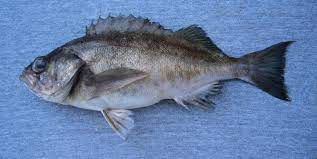"
catfish_path = tf.keras.utils.get_file('catfish', origin=catfish_url)

img = tf.keras.preprocessing.image.load_img(
    catfish_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

print(class_names[np.argmax(score)])
print(score)

# carp_url = "https://lh3.googleusercontent.com/proxy/eMuxcYh_Qyqq-RVHFsNXt-FnETiNVc4KQIo2Fuax1vGbYpJWEeHUTun00ujtFl3rPjRR6nHuWwVmHCAAeEwNuuRQWU8h8y_ClLv9L4cNiAFWpowKhdTxjXPeTQ_aWEy06EgIYolNM70jngdT79DkMev_EjQ"
carp_url = "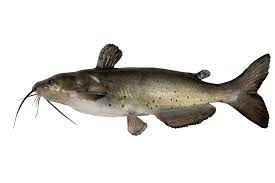"
carp_path = tf.keras.utils.get_file('carp', origin=carp_url)

img = tf.keras.preprocessing.image.load_img(
    carp_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

mandarin_url = "http://fish.darakwon.co.kr/fdata/fish/contents/info/images/20110427475B.jpg"
mandarin_path = tf.keras.utils.get_file('mandarin', origin=mandarin_url)

img = tf.keras.preprocessing.image.load_img(
    mandarin_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

bass_url = "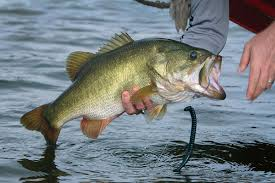"
bass_path = tf.keras.utils.get_file('bass', origin=bass_url)

img = tf.keras.preprocessing.image.load_img(
    bass_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

carp_url = "https://i.ytimg.com/vi/KlKg1LRnsMo/maxresdefault.jpg"
carp_path = tf.keras.utils.get_file('carp', origin=carp_url)

img = tf.keras.preprocessing.image.load_img(
    carp_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)